In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_dir = '/content/drive/MyDrive/pppo2/train'
test_dir = '/content/drive/MyDrive/pppo2/test'
img_size = 48

In [3]:
def load_images_to_df(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label)
    images = np.array(images).reshape(-1, img_size, img_size, 1)
    labels = pd.get_dummies(labels).values
    return pd.DataFrame({'Images': list(images), 'Labels': list(labels)})

In [4]:
train_df = load_images_to_df(train_dir)
validation_df = load_images_to_df(test_dir)

x_train = np.array(train_df['Images'].tolist())
y_train = np.array(train_df['Labels'].tolist())

x_val = np.array(validation_df['Images'].tolist())
y_val = np.array(validation_df['Labels'].tolist())


In [5]:
labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = validation_datagen.flow(x_val, y_val, batch_size=128)

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,050,583 (7.82 MB)

 Trainable params: 683,527 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,367,056 (5.21 MB)

In [10]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights_dict
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.1025 - loss: 1.9726

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 214s 948ms/step - accuracy: 0.1025 - loss: 1.9725 - val_accuracy: 0.1337 - val_loss: 1.9442
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 248s 888ms/step - accuracy: 0.1374 - loss: 1.9336 - val_accuracy: 0.1243 - val_loss: 1.9459
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 199s 884ms/step - accuracy: 0.1507 - loss: 1.9147 - val_accuracy: 0.1708 - val_loss: 1.9325
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 919ms/step - accuracy: 0.1672 - loss: 1.9255 - val_accuracy: 0.2113 - val_loss: 1.9133
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 199s 883ms/step - accuracy: 0.1976 - loss: 1.9045 - val_accuracy: 0.2462 - val_loss: 1.8898
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 199s 886ms/step - accuracy: 0.2068 - loss: 1.9012 - val_accuracy: 0.2568 - val_loss: 1.8799
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 201s 894ms/step - accuracy: 0.2211 - loss: 1.8926 - val_accuracy: 0.2654 - val_loss: 1.8519
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 201s 892ms/step - accuracy: 0.2232 - loss: 1.89

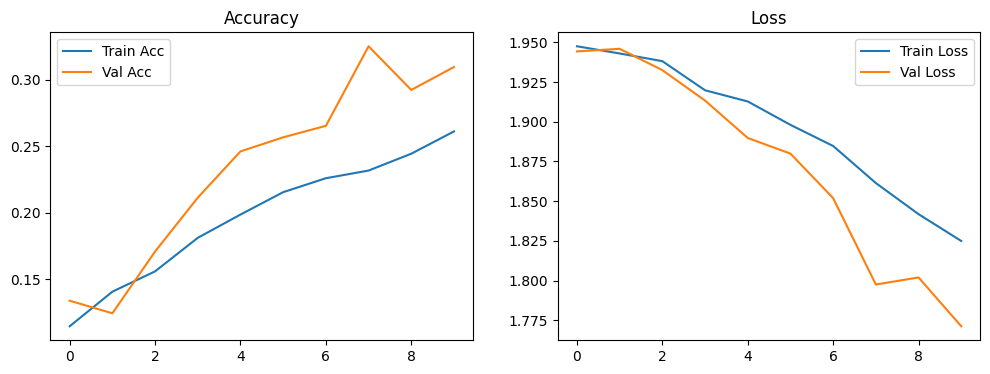

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history.history['accuracy'], label='Train Acc')
ax[0].plot(history.history['val_accuracy'], label='Val Acc')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_title('Loss')
ax[1].legend()

plt.show()

In [12]:
model.save('/content/drive/MyDrive/model_emo.h5')

In [13]:
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

class_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
   disgusted       0.02      0.18      0.03       111
     fearful       0.15      0.01      0.02      1024
       happy       0.23      0.15      0.18      1774
     neutral       0.15      0.14      0.15      1233
         sad       0.18      0.22      0.20      1247
   surprised       0.11      0.13      0.12       831

    accuracy                           0.14      7178
   macro avg       0.14      0.14      0.12      7178
weighted avg       0.16      0.14      0.14      7178



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


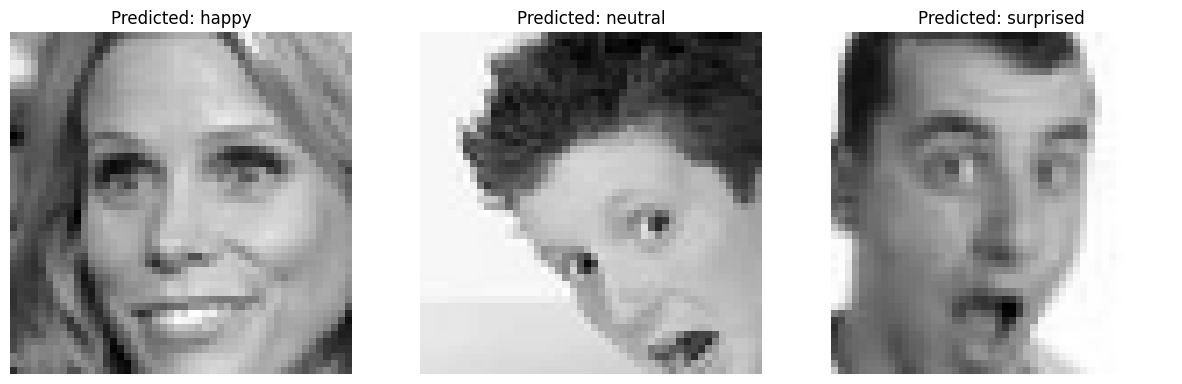

In [14]:
def preprocess_and_predict(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_array = np.expand_dims(img_resized, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    return img_resized, class_labels[predicted_class]

# Primer testiranja
test_image_paths = [
    '/content/drive/MyDrive/pppo2/test/happy/im41.png',
    '/content/drive/MyDrive/pppo2/test/fearful/im4.png',
    '/content/drive/MyDrive/pppo2/test/surprised/im5.png'
]

plt.figure(figsize=(15, 5))

for i, image_path in enumerate(test_image_paths):
    img, predicted_label = preprocess_and_predict(image_path, model)
    plt.subplot(1, len(test_image_paths), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')

plt.show()

**SPAJANJE SVA TRI MODELA**

In [19]:
from tensorflow.keras.models import load_model

# Učitaj model za godine
agemodel = load_model('/content/drive/MyDrive/model_age.h5')

# Učitaj model za pol
genmodel = load_model('./drive/MyDrive/model_gen.h5')

In [27]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Klase za emocije
class_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

def predict_all(image_path):
    im_rgb = Image.open(image_path).convert('RGB')

    width, height = im_rgb.size
    if width != height:
        if width > height:
            left = (width - height) / 2
            right = left + height
            im_rgb = im_rgb.crop((left, 0, right, height))
        else:
            top = (height - width) / 2
            bottom = top + width
            im_rgb = im_rgb.crop((0, top, width, bottom))

    im_rgb = im_rgb.resize((200, 200), Image.LANCZOS)
    ar_rgb = np.asarray(im_rgb).astype('float32') / 255.0
    ar_rgb = ar_rgb.reshape(1, 200, 200, 3)

    age = agemodel.predict(ar_rgb, verbose=0)[0][0]

    gender_pred = genmodel.predict(ar_rgb, verbose=0)[0][0]
    gender = 'female' if gender_pred >= 0.5 else 'male'

    im_gray = im_rgb.convert('L')
    im_gray = im_gray.resize((48, 48), Image.LANCZOS)
    ar_gray = np.asarray(im_gray).astype('float32') / 255.0
    ar_gray = ar_gray.reshape(1, 48, 48, 1)

    emotion_pred = model.predict(ar_gray, verbose=0)
    emotion_label = class_labels[np.argmax(emotion_pred)]

    plt.figure(figsize=(4, 4))
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.title(f'Age: {int(age)} | Gender: {gender} | Emotion: {emotion_label}')
    plt.show()

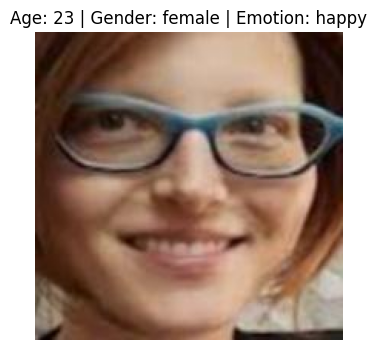

In [28]:
predict_all('/content/drive/MyDrive/crop_part1/28_1_0_20170109003005024.jpg.chip.jpg')

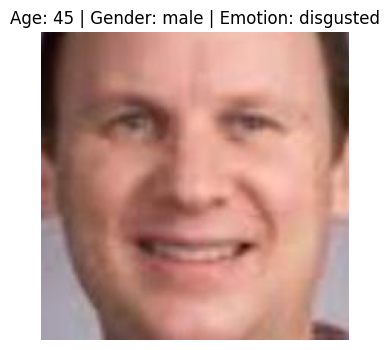

In [32]:
predict_all('/content/drive/MyDrive/crop_part1/39_0_0_20170105172508901.jpg.chip.jpg')

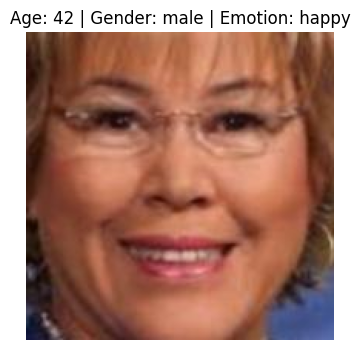

In [33]:
predict_all('/content/drive/MyDrive/crop_part1/52_1_0_20170105184031767.jpg.chip.jpg')